## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **OLD DATASET LOADER**

In [2]:
# # Loading CIFAR 100 dataset
# def CIFAR100DataLoader(
#     split, batch_size=8, num_workers=2, shuffle=True, size="32", normalize="standard"
# ):
#     """
#     A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
#     the parameters supplied and applies the required data augmentations.

#     Args:
#         split: A string to decide if train or test data to be used (Values: 'train', 'test')
#         batch_size: Batch size to used for loading data (Default=8)
#         num_workers: Number of parallel workers used to load data (Default=2)
#         shuffle: Boolean value to decide if data should be randomized (Default=True)
#         size: A string to decide the size of the input images (Default='32') (Values: '32','224')
#         normalize: A string to decide the normalization to applied to the input images
#                    (Default='standard') (Values: 'standard', 'imagenet')

#     Output:
#         DataLoader Object
#     """
#     if normalize == "imagenet":
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#     elif normalize == "standard":
#         mean = [0.5, 0.5, 0.5]
#         std = [0.5, 0.5, 0.5]

#     if split == "train":
#         if size == "224":
#             train_transform = transforms.Compose(
#                 [
#                     transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )
#         elif size == "32":
#             train_transform = transforms.Compose(
#                 [
#                     transforms.RandomCrop(32, padding=4),
#                     transforms.RandomHorizontalFlip(),
#                     transforms.RandomRotation(15),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )

#         cifar100 = torchvision.datasets.CIFAR100(
#             root="data", train=True, download=True, transform=train_transform
#         )
#         dataloader = DataLoader(
#             cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
#         )

#     elif split == "test":
#         if size == "224":
#             test_transform = transforms.Compose(
#                 [
#                     transforms.Resize((224, 224)),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )

#         elif size == "32":
#             test_transform = transforms.Compose(
#                 [transforms.ToTensor(), transforms.Normalize(mean, std)]
#             )

#         cifar100 = torchvision.datasets.CIFAR100(
#             root="./data", train=False, download=True, transform=test_transform
#         )
#         dataloader = DataLoader(
#             cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle
#         )

#     return dataloader

## **NEW DATASET LOADER**

In [3]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            transform_list.extend(
                [
                    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                ]
            )
    elif split == "test":
        if size == "224":
            transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [4]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [5]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [6]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [7]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [8]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 16
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 12
heads = 12

resnet_features_channels = 64

In [9]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [10]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:02<00:00, 68049042.92it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [12]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch16-768d-12h-12l_data_augmentation_CIFAR100_checkpoint.pt",
        )

        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch16-768d-12h-12l_data_augmentation_CIFAR100_checkpoint.pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch16-768d-12h-12l_data_augmentation_CIFAR100.pt",
)

# print(train_accs)
# print(test_accs)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [01:04<00:00, 24.36it/s]


Epoch : 1 - acc: 0.0807 - loss : 4.1073



100%|██████████| 313/313 [00:03<00:00, 91.23it/s]


test acc: 0.1290 - test loss : 3.7919



100%|██████████| 1563/1563 [01:04<00:00, 24.41it/s]


Epoch : 2 - acc: 0.1332 - loss : 3.7460



100%|██████████| 313/313 [00:03<00:00, 83.14it/s]


test acc: 0.1570 - test loss : 3.6025



100%|██████████| 1563/1563 [01:04<00:00, 24.38it/s]


Epoch : 3 - acc: 0.1576 - loss : 3.5918



100%|██████████| 313/313 [00:03<00:00, 80.17it/s]


test acc: 0.1826 - test loss : 3.4794



100%|██████████| 1563/1563 [01:03<00:00, 24.66it/s]


Epoch : 4 - acc: 0.1783 - loss : 3.4635



100%|██████████| 313/313 [00:03<00:00, 80.22it/s]


test acc: 0.1985 - test loss : 3.3660



100%|██████████| 1563/1563 [01:03<00:00, 24.52it/s]


Epoch : 5 - acc: 0.1969 - loss : 3.3584



100%|██████████| 313/313 [00:03<00:00, 83.57it/s]


test acc: 0.2144 - test loss : 3.2946



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 6 - acc: 0.2103 - loss : 3.2761



100%|██████████| 313/313 [00:03<00:00, 88.85it/s]


test acc: 0.2219 - test loss : 3.2443



100%|██████████| 1563/1563 [01:04<00:00, 24.30it/s]


Epoch : 7 - acc: 0.2237 - loss : 3.1994



100%|██████████| 313/313 [00:03<00:00, 87.56it/s]


test acc: 0.2326 - test loss : 3.1795



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 8 - acc: 0.2338 - loss : 3.1401



100%|██████████| 313/313 [00:03<00:00, 91.26it/s] 


test acc: 0.2409 - test loss : 3.1505



100%|██████████| 1563/1563 [01:03<00:00, 24.46it/s]


Epoch : 9 - acc: 0.2426 - loss : 3.0827



100%|██████████| 313/313 [00:04<00:00, 75.50it/s]


test acc: 0.2482 - test loss : 3.1128



100%|██████████| 1563/1563 [01:02<00:00, 24.84it/s]


Epoch : 10 - acc: 0.2554 - loss : 3.0325



100%|██████████| 313/313 [00:03<00:00, 87.75it/s]


test acc: 0.2533 - test loss : 3.1006



100%|██████████| 1563/1563 [01:03<00:00, 24.56it/s]


Epoch : 11 - acc: 0.2603 - loss : 2.9905



100%|██████████| 313/313 [00:03<00:00, 84.77it/s]


test acc: 0.2561 - test loss : 3.0517



100%|██████████| 1563/1563 [01:04<00:00, 24.08it/s]


Epoch : 12 - acc: 0.2719 - loss : 2.9348



100%|██████████| 313/313 [00:03<00:00, 92.26it/s] 


test acc: 0.2697 - test loss : 3.0231



100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]


Epoch : 13 - acc: 0.2779 - loss : 2.9030



100%|██████████| 313/313 [00:03<00:00, 88.87it/s]


test acc: 0.2742 - test loss : 3.0144



100%|██████████| 1563/1563 [01:05<00:00, 24.01it/s]


Epoch : 14 - acc: 0.2845 - loss : 2.8564



100%|██████████| 313/313 [00:03<00:00, 91.56it/s]


test acc: 0.2790 - test loss : 2.9705



100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Epoch : 15 - acc: 0.2943 - loss : 2.8191



100%|██████████| 313/313 [00:03<00:00, 83.15it/s]


test acc: 0.2808 - test loss : 2.9650



100%|██████████| 1563/1563 [01:02<00:00, 24.89it/s]


Epoch : 16 - acc: 0.2988 - loss : 2.7819



100%|██████████| 313/313 [00:03<00:00, 89.51it/s]


test acc: 0.2859 - test loss : 2.9442



100%|██████████| 1563/1563 [01:03<00:00, 24.67it/s]


Epoch : 17 - acc: 0.3062 - loss : 2.7542



100%|██████████| 313/313 [00:03<00:00, 84.10it/s]


test acc: 0.2819 - test loss : 2.9500



100%|██████████| 1563/1563 [01:03<00:00, 24.64it/s]


Epoch : 18 - acc: 0.3138 - loss : 2.7175



100%|██████████| 313/313 [00:03<00:00, 89.09it/s]


test acc: 0.2893 - test loss : 2.9377



100%|██████████| 1563/1563 [01:03<00:00, 24.48it/s]


Epoch : 19 - acc: 0.3198 - loss : 2.6919



100%|██████████| 313/313 [00:03<00:00, 86.27it/s] 


test acc: 0.2888 - test loss : 2.9191



100%|██████████| 1563/1563 [01:04<00:00, 24.19it/s]


Epoch : 20 - acc: 0.3246 - loss : 2.6548



100%|██████████| 313/313 [00:03<00:00, 91.76it/s]


test acc: 0.2981 - test loss : 2.9105



100%|██████████| 1563/1563 [01:03<00:00, 24.70it/s]


Epoch : 21 - acc: 0.3311 - loss : 2.6203



100%|██████████| 313/313 [00:03<00:00, 87.16it/s]


test acc: 0.3007 - test loss : 2.8896



100%|██████████| 1563/1563 [01:04<00:00, 24.40it/s]


Epoch : 22 - acc: 0.3385 - loss : 2.5888



100%|██████████| 313/313 [00:03<00:00, 85.29it/s]


test acc: 0.2985 - test loss : 2.9002



100%|██████████| 1563/1563 [01:05<00:00, 23.83it/s]


Epoch : 23 - acc: 0.3443 - loss : 2.5555



100%|██████████| 313/313 [00:03<00:00, 89.34it/s]


test acc: 0.2994 - test loss : 2.8843



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 24 - acc: 0.3496 - loss : 2.5277



100%|██████████| 313/313 [00:03<00:00, 85.56it/s]


test acc: 0.3101 - test loss : 2.8748



100%|██████████| 1563/1563 [01:04<00:00, 24.27it/s]


Epoch : 25 - acc: 0.3553 - loss : 2.4903



100%|██████████| 313/313 [00:03<00:00, 87.32it/s] 


test acc: 0.3063 - test loss : 2.8793



100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Epoch : 26 - acc: 0.3628 - loss : 2.4679



100%|██████████| 313/313 [00:03<00:00, 92.46it/s]


test acc: 0.3023 - test loss : 2.8738



100%|██████████| 1563/1563 [01:05<00:00, 24.02it/s]


Epoch : 27 - acc: 0.3689 - loss : 2.4369



100%|██████████| 313/313 [00:03<00:00, 79.43it/s]


test acc: 0.3067 - test loss : 2.8709



100%|██████████| 1563/1563 [01:03<00:00, 24.68it/s]


Epoch : 28 - acc: 0.3715 - loss : 2.4100



100%|██████████| 313/313 [00:03<00:00, 86.19it/s]


test acc: 0.3098 - test loss : 2.8487



100%|██████████| 1563/1563 [01:03<00:00, 24.48it/s]


Epoch : 29 - acc: 0.3794 - loss : 2.3832



100%|██████████| 313/313 [00:03<00:00, 82.03it/s]


test acc: 0.3179 - test loss : 2.8589



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 30 - acc: 0.3829 - loss : 2.3512



100%|██████████| 313/313 [00:03<00:00, 85.74it/s]


test acc: 0.3145 - test loss : 2.8751



100%|██████████| 1563/1563 [01:04<00:00, 24.05it/s]


Epoch : 31 - acc: 0.3928 - loss : 2.3189



100%|██████████| 313/313 [00:03<00:00, 82.18it/s]


test acc: 0.3138 - test loss : 2.8731



100%|██████████| 1563/1563 [01:03<00:00, 24.61it/s]


Epoch : 32 - acc: 0.3966 - loss : 2.2897



100%|██████████| 313/313 [00:03<00:00, 84.93it/s]


test acc: 0.3211 - test loss : 2.8493



100%|██████████| 1563/1563 [01:04<00:00, 24.09it/s]


Epoch : 33 - acc: 0.4021 - loss : 2.2720



100%|██████████| 313/313 [00:03<00:00, 88.31it/s] 


test acc: 0.3141 - test loss : 2.8444



100%|██████████| 1563/1563 [01:03<00:00, 24.54it/s]


Epoch : 34 - acc: 0.4043 - loss : 2.2455



100%|██████████| 313/313 [00:03<00:00, 85.18it/s]


test acc: 0.3213 - test loss : 2.8487



100%|██████████| 1563/1563 [01:04<00:00, 24.11it/s]


Epoch : 35 - acc: 0.4131 - loss : 2.2183



100%|██████████| 313/313 [00:03<00:00, 81.85it/s]


test acc: 0.3175 - test loss : 2.8437



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 36 - acc: 0.4179 - loss : 2.1871



100%|██████████| 313/313 [00:03<00:00, 91.96it/s] 


test acc: 0.3276 - test loss : 2.8374



100%|██████████| 1563/1563 [01:04<00:00, 24.33it/s]


Epoch : 37 - acc: 0.4231 - loss : 2.1656



100%|██████████| 313/313 [00:03<00:00, 85.08it/s]


test acc: 0.3203 - test loss : 2.8614



100%|██████████| 1563/1563 [01:04<00:00, 24.33it/s]


Epoch : 38 - acc: 0.4276 - loss : 2.1403



100%|██████████| 313/313 [00:03<00:00, 86.73it/s] 


test acc: 0.3285 - test loss : 2.8548



100%|██████████| 1563/1563 [01:04<00:00, 24.11it/s]


Epoch : 39 - acc: 0.4356 - loss : 2.1150



100%|██████████| 313/313 [00:03<00:00, 91.95it/s] 


test acc: 0.3213 - test loss : 2.8671



100%|██████████| 1563/1563 [01:04<00:00, 24.37it/s]


Epoch : 40 - acc: 0.4407 - loss : 2.0892



100%|██████████| 313/313 [00:03<00:00, 89.87it/s]


test acc: 0.3293 - test loss : 2.8418



100%|██████████| 1563/1563 [01:03<00:00, 24.51it/s]


Epoch : 41 - acc: 0.4412 - loss : 2.0642



100%|██████████| 313/313 [00:04<00:00, 77.37it/s]


test acc: 0.3265 - test loss : 2.8578



100%|██████████| 1563/1563 [01:03<00:00, 24.48it/s]


Epoch : 42 - acc: 0.4505 - loss : 2.0403



100%|██████████| 313/313 [00:03<00:00, 89.77it/s] 


test acc: 0.3246 - test loss : 2.8640



100%|██████████| 1563/1563 [01:03<00:00, 24.63it/s]


Epoch : 43 - acc: 0.4552 - loss : 2.0138



100%|██████████| 313/313 [00:03<00:00, 89.37it/s]


test acc: 0.3268 - test loss : 2.8588



100%|██████████| 1563/1563 [01:04<00:00, 24.30it/s]


Epoch : 44 - acc: 0.4644 - loss : 1.9774



100%|██████████| 313/313 [00:03<00:00, 89.84it/s]


test acc: 0.3283 - test loss : 2.8847



100%|██████████| 1563/1563 [01:05<00:00, 24.03it/s]


Epoch : 45 - acc: 0.4665 - loss : 1.9598



100%|██████████| 313/313 [00:03<00:00, 84.29it/s]


test acc: 0.3304 - test loss : 2.9009



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 46 - acc: 0.4738 - loss : 1.9347



100%|██████████| 313/313 [00:03<00:00, 87.37it/s]


test acc: 0.3230 - test loss : 2.8905



100%|██████████| 1563/1563 [01:04<00:00, 24.40it/s]


Epoch : 47 - acc: 0.4793 - loss : 1.9041



100%|██████████| 313/313 [00:03<00:00, 88.78it/s]


test acc: 0.3314 - test loss : 2.8992



100%|██████████| 1563/1563 [01:04<00:00, 24.05it/s]


Epoch : 48 - acc: 0.4857 - loss : 1.8787



100%|██████████| 313/313 [00:03<00:00, 83.04it/s]


test acc: 0.3303 - test loss : 2.9149



100%|██████████| 1563/1563 [01:04<00:00, 24.09it/s]


Epoch : 49 - acc: 0.4920 - loss : 1.8534



100%|██████████| 313/313 [00:03<00:00, 86.13it/s]


test acc: 0.3303 - test loss : 2.8878



100%|██████████| 1563/1563 [01:05<00:00, 24.00it/s]


Epoch : 50 - acc: 0.4934 - loss : 1.8392



100%|██████████| 313/313 [00:03<00:00, 92.67it/s]


test acc: 0.3390 - test loss : 2.8948



100%|██████████| 1563/1563 [01:04<00:00, 24.24it/s]


Epoch : 51 - acc: 0.4993 - loss : 1.8180



100%|██████████| 313/313 [00:03<00:00, 79.08it/s]


test acc: 0.3311 - test loss : 2.9116



100%|██████████| 1563/1563 [01:05<00:00, 23.94it/s]


Epoch : 52 - acc: 0.5050 - loss : 1.7936



100%|██████████| 313/313 [00:03<00:00, 87.97it/s]


test acc: 0.3267 - test loss : 2.9440



100%|██████████| 1563/1563 [01:03<00:00, 24.71it/s]


Epoch : 53 - acc: 0.5097 - loss : 1.7637



100%|██████████| 313/313 [00:03<00:00, 93.00it/s] 


test acc: 0.3319 - test loss : 2.9664



100%|██████████| 1563/1563 [01:03<00:00, 24.43it/s]


Epoch : 54 - acc: 0.5143 - loss : 1.7470



100%|██████████| 313/313 [00:03<00:00, 86.37it/s]


test acc: 0.3353 - test loss : 2.9481



100%|██████████| 1563/1563 [01:03<00:00, 24.61it/s]


Epoch : 55 - acc: 0.5226 - loss : 1.7265



100%|██████████| 313/313 [00:03<00:00, 87.81it/s]


test acc: 0.3347 - test loss : 2.9674



100%|██████████| 1563/1563 [01:04<00:00, 24.24it/s]


Epoch : 56 - acc: 0.5232 - loss : 1.7121



100%|██████████| 313/313 [00:03<00:00, 89.13it/s]


test acc: 0.3296 - test loss : 2.9920



100%|██████████| 1563/1563 [01:03<00:00, 24.50it/s]


Epoch : 57 - acc: 0.5316 - loss : 1.6772



100%|██████████| 313/313 [00:03<00:00, 93.63it/s] 


test acc: 0.3359 - test loss : 2.9768



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 58 - acc: 0.5359 - loss : 1.6606



100%|██████████| 313/313 [00:03<00:00, 81.49it/s]


test acc: 0.3350 - test loss : 3.0086



100%|██████████| 1563/1563 [01:07<00:00, 23.09it/s]


Epoch : 59 - acc: 0.5442 - loss : 1.6329



100%|██████████| 313/313 [00:03<00:00, 88.49it/s]


test acc: 0.3346 - test loss : 3.0009



100%|██████████| 1563/1563 [01:04<00:00, 24.06it/s]


Epoch : 60 - acc: 0.5434 - loss : 1.6191



100%|██████████| 313/313 [00:03<00:00, 87.75it/s]


test acc: 0.3315 - test loss : 3.0339



100%|██████████| 1563/1563 [01:04<00:00, 24.33it/s]


Epoch : 61 - acc: 0.5497 - loss : 1.6056



100%|██████████| 313/313 [00:03<00:00, 87.36it/s]


test acc: 0.3345 - test loss : 3.0481



100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s]


Epoch : 62 - acc: 0.5575 - loss : 1.5775



100%|██████████| 313/313 [00:03<00:00, 88.33it/s]


test acc: 0.3387 - test loss : 3.0344



100%|██████████| 1563/1563 [01:04<00:00, 24.31it/s]


Epoch : 63 - acc: 0.5646 - loss : 1.5508



100%|██████████| 313/313 [00:03<00:00, 90.26it/s]


test acc: 0.3364 - test loss : 3.0289



100%|██████████| 1563/1563 [01:05<00:00, 23.77it/s]


Epoch : 64 - acc: 0.5680 - loss : 1.5313



100%|██████████| 313/313 [00:03<00:00, 86.03it/s]


test acc: 0.3303 - test loss : 3.0978



100%|██████████| 1563/1563 [01:05<00:00, 23.90it/s]


Epoch : 65 - acc: 0.5728 - loss : 1.4996



100%|██████████| 313/313 [00:03<00:00, 89.37it/s]


test acc: 0.3385 - test loss : 3.0804



100%|██████████| 1563/1563 [01:04<00:00, 24.25it/s]


Epoch : 66 - acc: 0.5708 - loss : 1.5099



100%|██████████| 313/313 [00:03<00:00, 85.23it/s]


test acc: 0.3304 - test loss : 3.0933



100%|██████████| 1563/1563 [01:03<00:00, 24.46it/s]


Epoch : 67 - acc: 0.5809 - loss : 1.4725



100%|██████████| 313/313 [00:04<00:00, 78.11it/s]


test acc: 0.3386 - test loss : 3.0900



100%|██████████| 1563/1563 [01:03<00:00, 24.44it/s]


Epoch : 68 - acc: 0.5827 - loss : 1.4505



100%|██████████| 313/313 [00:03<00:00, 88.11it/s]


test acc: 0.3398 - test loss : 3.1150



100%|██████████| 1563/1563 [01:04<00:00, 24.32it/s]


Epoch : 69 - acc: 0.5904 - loss : 1.4310



100%|██████████| 313/313 [00:03<00:00, 93.45it/s] 


test acc: 0.3384 - test loss : 3.1399



100%|██████████| 1563/1563 [01:04<00:00, 24.39it/s]


Epoch : 70 - acc: 0.5913 - loss : 1.4164



100%|██████████| 313/313 [00:03<00:00, 87.55it/s]


test acc: 0.3386 - test loss : 3.1203



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 71 - acc: 0.5955 - loss : 1.4073



100%|██████████| 313/313 [00:03<00:00, 86.22it/s]


test acc: 0.3300 - test loss : 3.1552



100%|██████████| 1563/1563 [01:04<00:00, 24.10it/s]


Epoch : 72 - acc: 0.6025 - loss : 1.3863



100%|██████████| 313/313 [00:03<00:00, 88.90it/s]


test acc: 0.3366 - test loss : 3.1530



100%|██████████| 1563/1563 [01:04<00:00, 24.17it/s]


Epoch : 73 - acc: 0.6073 - loss : 1.3700



100%|██████████| 313/313 [00:03<00:00, 92.43it/s] 


test acc: 0.3378 - test loss : 3.1828



100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]


Epoch : 74 - acc: 0.6140 - loss : 1.3388



100%|██████████| 313/313 [00:03<00:00, 87.56it/s]


test acc: 0.3426 - test loss : 3.1711



100%|██████████| 1563/1563 [01:04<00:00, 24.10it/s]


Epoch : 75 - acc: 0.6189 - loss : 1.3156



100%|██████████| 313/313 [00:03<00:00, 85.99it/s]


test acc: 0.3325 - test loss : 3.2228



100%|██████████| 1563/1563 [01:05<00:00, 24.02it/s]


Epoch : 76 - acc: 0.6238 - loss : 1.2948



100%|██████████| 313/313 [00:03<00:00, 88.52it/s]


test acc: 0.3361 - test loss : 3.2310



100%|██████████| 1563/1563 [01:04<00:00, 24.23it/s]


Epoch : 77 - acc: 0.6311 - loss : 1.2752



100%|██████████| 313/313 [00:04<00:00, 76.43it/s]


test acc: 0.3371 - test loss : 3.2340



100%|██████████| 1563/1563 [01:03<00:00, 24.50it/s]


Epoch : 78 - acc: 0.6337 - loss : 1.2621



100%|██████████| 313/313 [00:04<00:00, 71.63it/s]


test acc: 0.3331 - test loss : 3.2605



100%|██████████| 1563/1563 [01:04<00:00, 24.24it/s]


Epoch : 79 - acc: 0.6367 - loss : 1.2410



100%|██████████| 313/313 [00:03<00:00, 88.70it/s]


test acc: 0.3340 - test loss : 3.2843



100%|██████████| 1563/1563 [01:04<00:00, 24.22it/s]


Epoch : 80 - acc: 0.6452 - loss : 1.2186



100%|██████████| 313/313 [00:03<00:00, 89.19it/s]


test acc: 0.3373 - test loss : 3.2755



100%|██████████| 1563/1563 [01:05<00:00, 23.78it/s]


Epoch : 81 - acc: 0.6493 - loss : 1.2043



100%|██████████| 313/313 [00:03<00:00, 92.43it/s]


test acc: 0.3318 - test loss : 3.3183



100%|██████████| 1563/1563 [01:04<00:00, 24.37it/s]


Epoch : 82 - acc: 0.6510 - loss : 1.1891



100%|██████████| 313/313 [00:03<00:00, 93.04it/s] 


test acc: 0.3420 - test loss : 3.2862



100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Epoch : 83 - acc: 0.6583 - loss : 1.1677



100%|██████████| 313/313 [00:03<00:00, 92.09it/s] 


test acc: 0.3433 - test loss : 3.2830



100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Epoch : 84 - acc: 0.6628 - loss : 1.1603



100%|██████████| 313/313 [00:03<00:00, 92.31it/s]


test acc: 0.3335 - test loss : 3.3291



100%|██████████| 1563/1563 [01:05<00:00, 24.01it/s]


Epoch : 85 - acc: 0.6611 - loss : 1.1448



100%|██████████| 313/313 [00:03<00:00, 92.20it/s]


test acc: 0.3398 - test loss : 3.3285



100%|██████████| 1563/1563 [01:04<00:00, 24.38it/s]


Epoch : 86 - acc: 0.6687 - loss : 1.1318



100%|██████████| 313/313 [00:03<00:00, 93.83it/s]


test acc: 0.3370 - test loss : 3.3543



100%|██████████| 1563/1563 [01:03<00:00, 24.51it/s]


Epoch : 87 - acc: 0.6716 - loss : 1.1214



100%|██████████| 313/313 [00:03<00:00, 85.86it/s]


test acc: 0.3402 - test loss : 3.3801



100%|██████████| 1563/1563 [01:04<00:00, 24.23it/s]


Epoch : 88 - acc: 0.6747 - loss : 1.1063



100%|██████████| 313/313 [00:03<00:00, 89.27it/s]


test acc: 0.3435 - test loss : 3.3756



100%|██████████| 1563/1563 [01:04<00:00, 24.08it/s]


Epoch : 89 - acc: 0.6817 - loss : 1.0805



100%|██████████| 313/313 [00:03<00:00, 87.89it/s]


test acc: 0.3351 - test loss : 3.4051



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 90 - acc: 0.6866 - loss : 1.0620



100%|██████████| 313/313 [00:03<00:00, 82.32it/s]


test acc: 0.3371 - test loss : 3.4460



100%|██████████| 1563/1563 [01:05<00:00, 24.02it/s]


Epoch : 91 - acc: 0.6881 - loss : 1.0573



100%|██████████| 313/313 [00:03<00:00, 91.76it/s]


test acc: 0.3440 - test loss : 3.4267



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 92 - acc: 0.6928 - loss : 1.0362



100%|██████████| 313/313 [00:03<00:00, 85.63it/s]


test acc: 0.3414 - test loss : 3.4213



100%|██████████| 1563/1563 [01:06<00:00, 23.58it/s]


Epoch : 93 - acc: 0.6966 - loss : 1.0217



100%|██████████| 313/313 [00:03<00:00, 79.34it/s]


test acc: 0.3388 - test loss : 3.4394



100%|██████████| 1563/1563 [01:03<00:00, 24.43it/s]


Epoch : 94 - acc: 0.6992 - loss : 1.0092



100%|██████████| 313/313 [00:03<00:00, 78.83it/s] 


test acc: 0.3349 - test loss : 3.4742



100%|██████████| 1563/1563 [01:04<00:00, 24.28it/s]


Epoch : 95 - acc: 0.6990 - loss : 1.0097



100%|██████████| 313/313 [00:03<00:00, 81.91it/s]


test acc: 0.3382 - test loss : 3.5017



100%|██████████| 1563/1563 [01:03<00:00, 24.46it/s]


Epoch : 96 - acc: 0.7026 - loss : 0.9943



100%|██████████| 313/313 [00:03<00:00, 90.10it/s]


test acc: 0.3419 - test loss : 3.5175



100%|██████████| 1563/1563 [01:04<00:00, 24.11it/s]


Epoch : 97 - acc: 0.7087 - loss : 0.9736



100%|██████████| 313/313 [00:03<00:00, 88.17it/s]


test acc: 0.3379 - test loss : 3.5317



100%|██████████| 1563/1563 [01:03<00:00, 24.46it/s]


Epoch : 98 - acc: 0.7128 - loss : 0.9677



100%|██████████| 313/313 [00:03<00:00, 86.41it/s]


test acc: 0.3377 - test loss : 3.5372



100%|██████████| 1563/1563 [01:04<00:00, 24.09it/s]


Epoch : 99 - acc: 0.7165 - loss : 0.9501



100%|██████████| 313/313 [00:03<00:00, 87.26it/s]


test acc: 0.3397 - test loss : 3.5396



100%|██████████| 1563/1563 [01:04<00:00, 24.37it/s]


Epoch : 100 - acc: 0.7226 - loss : 0.9327



100%|██████████| 313/313 [00:03<00:00, 90.41it/s]


test acc: 0.3395 - test loss : 3.5547

Start Time: 1732169427.5165076
End Time: 1732176257.4732382
Time Taken: 6829.956730604172 seconds


In [13]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

/tmp/ipykernel_36/3010096064.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


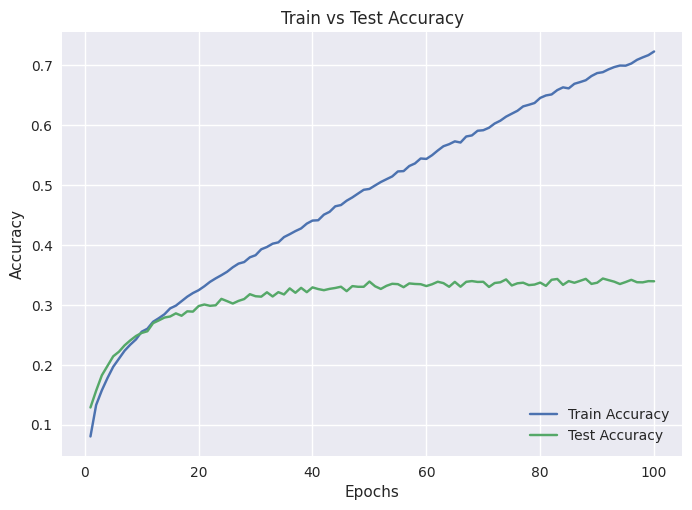

In [14]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [15]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:03<00:00, 92.82it/s]


####  Superclass confusion matrix

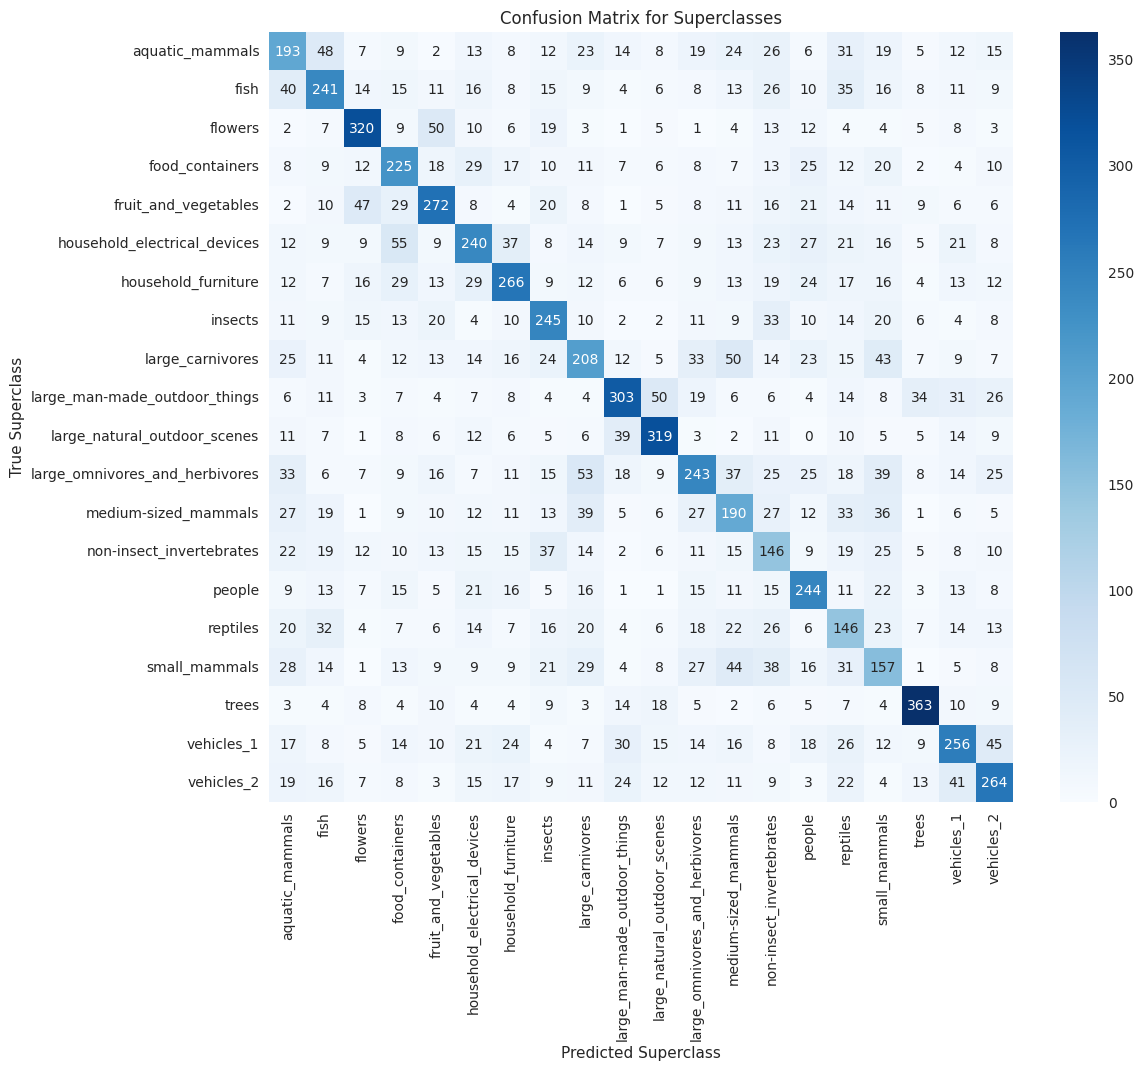

In [16]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

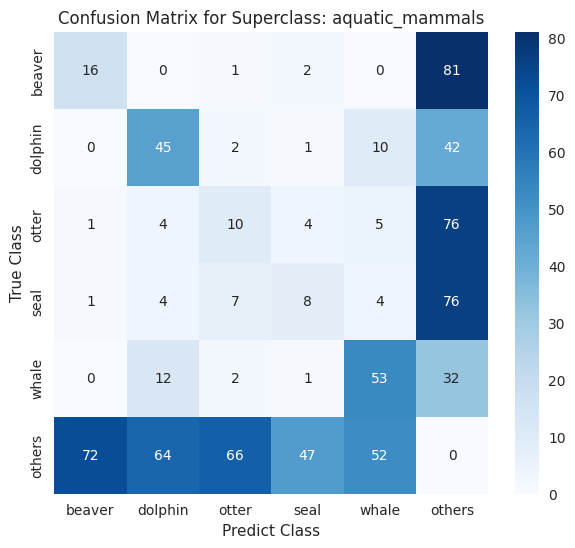

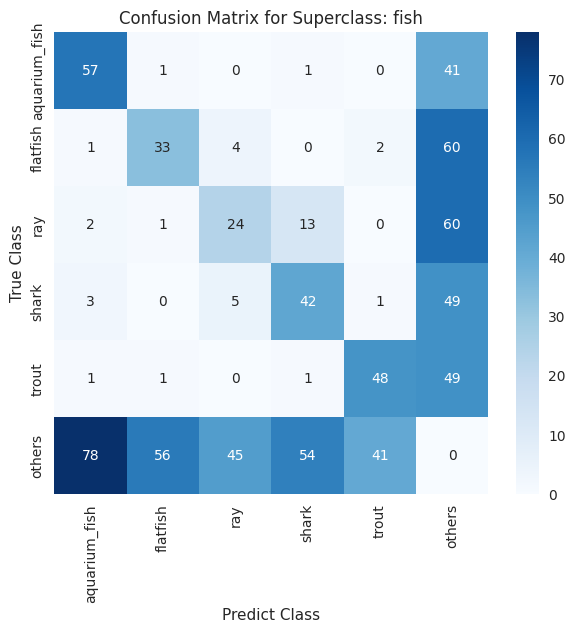

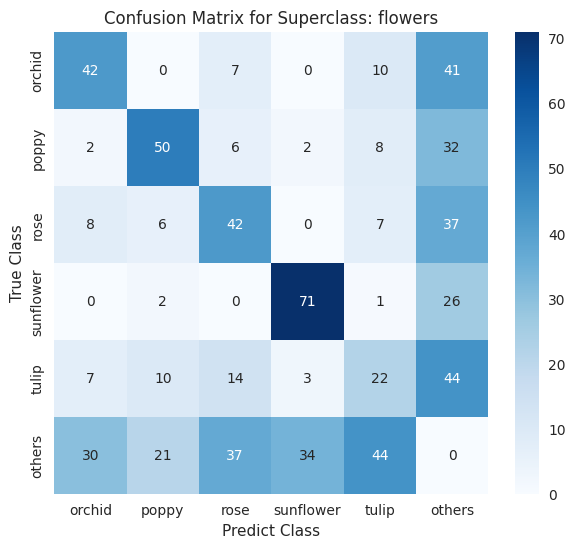

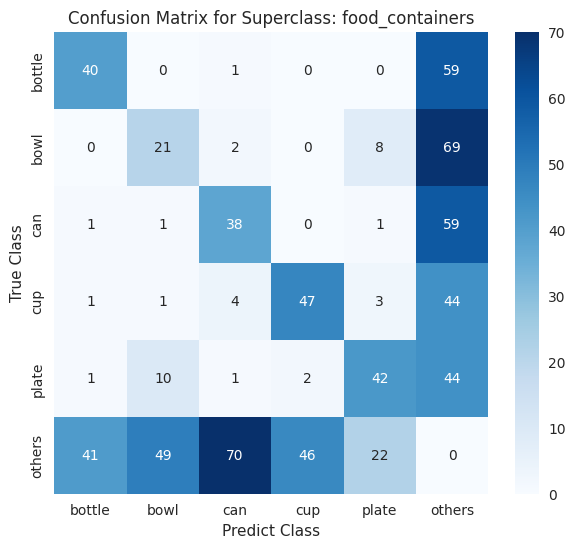

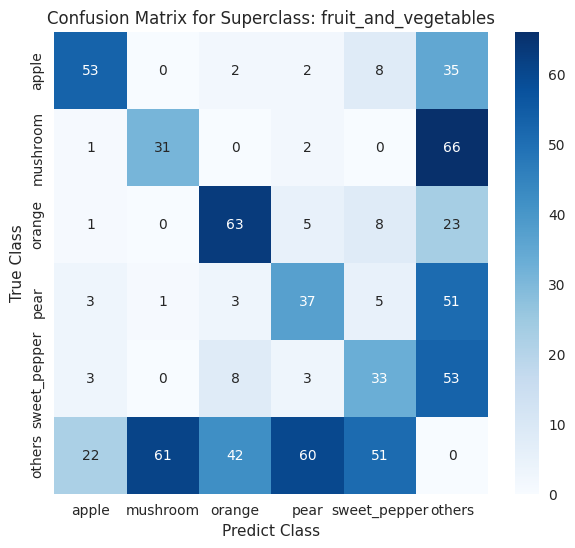

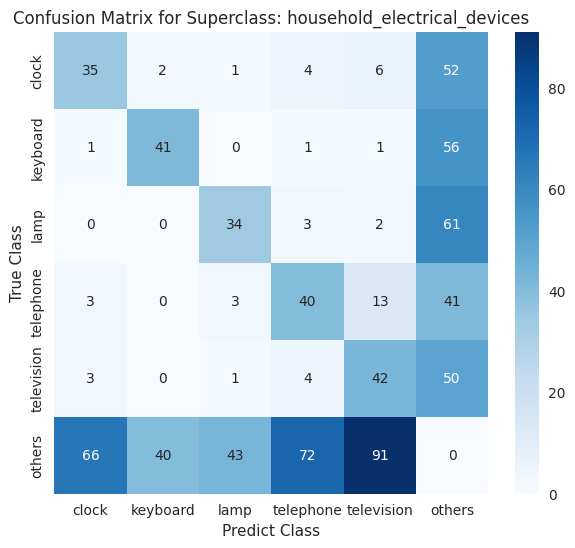

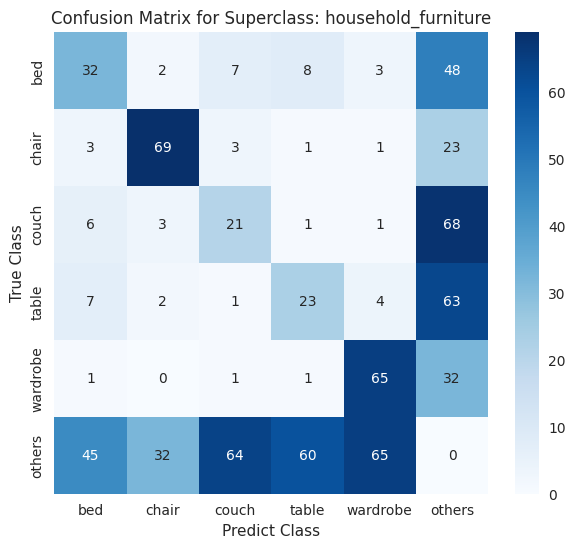

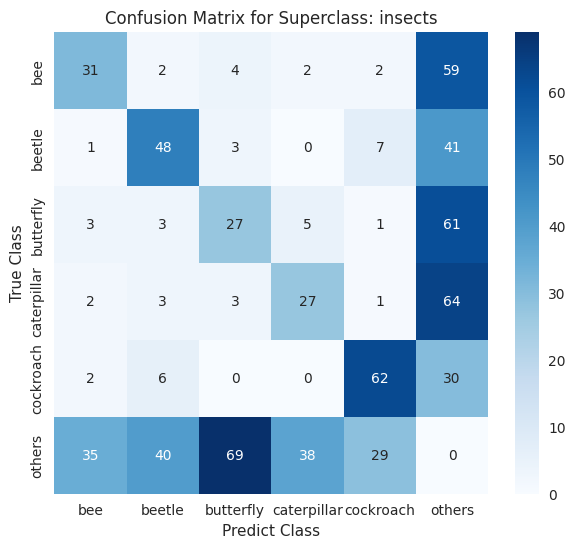

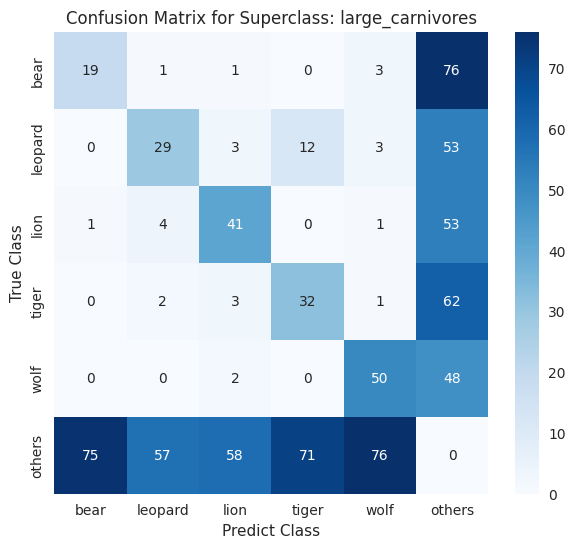

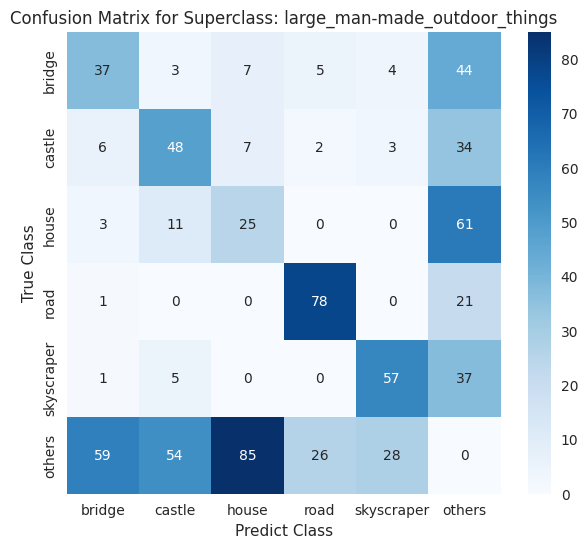

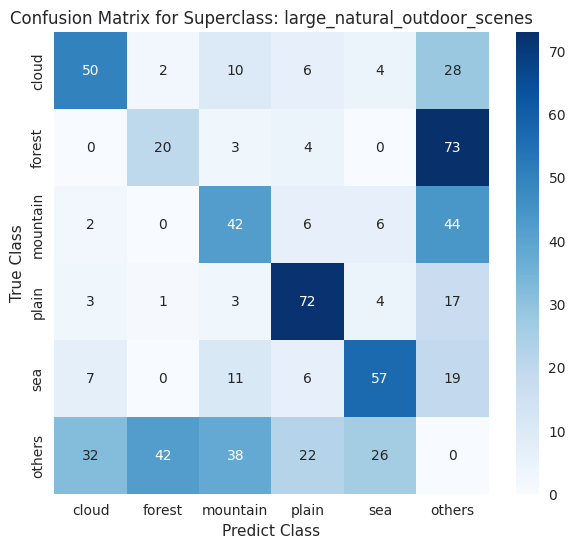

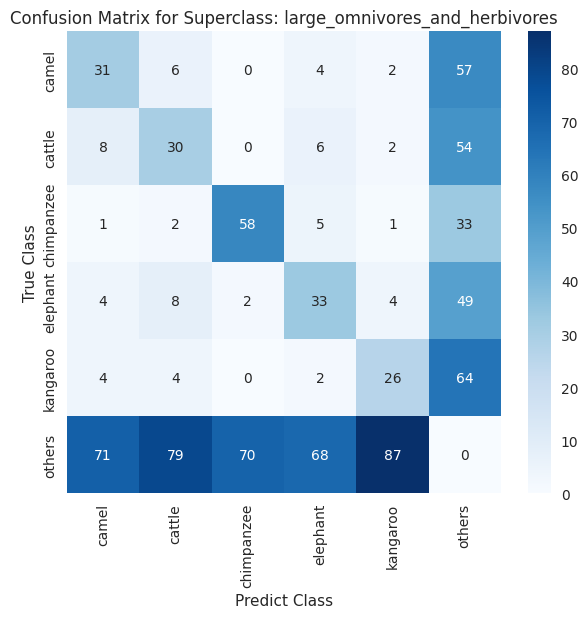

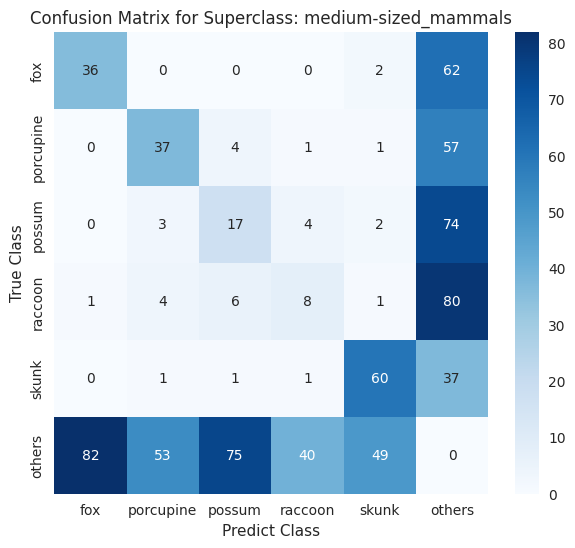

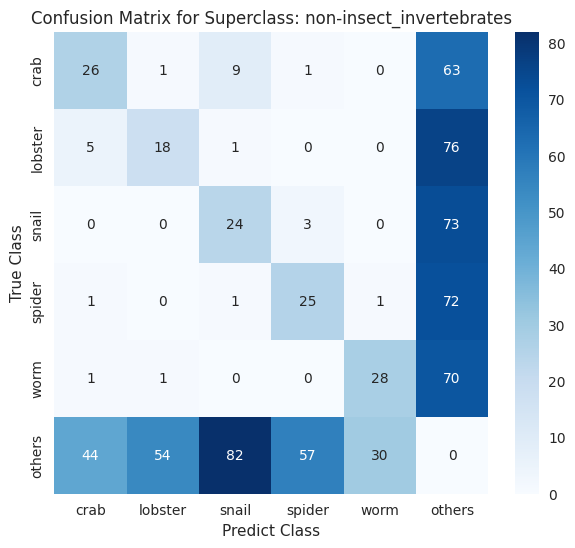

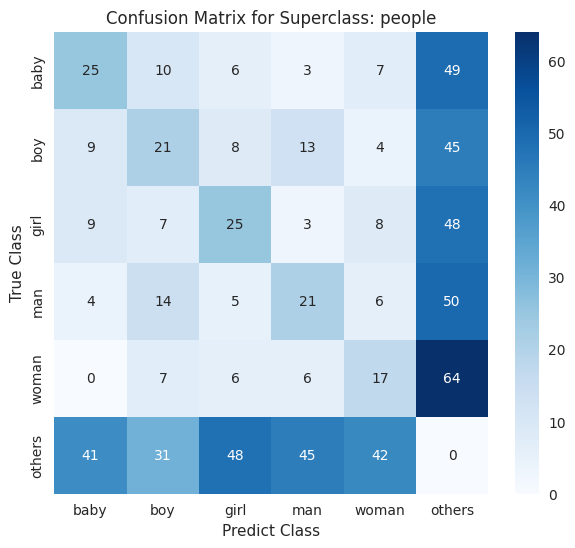

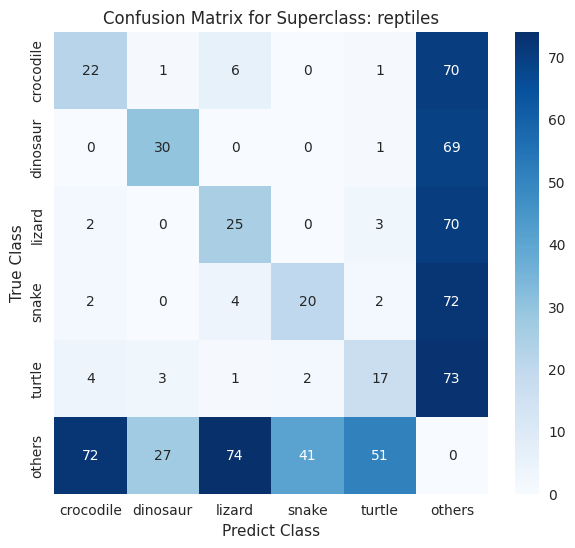

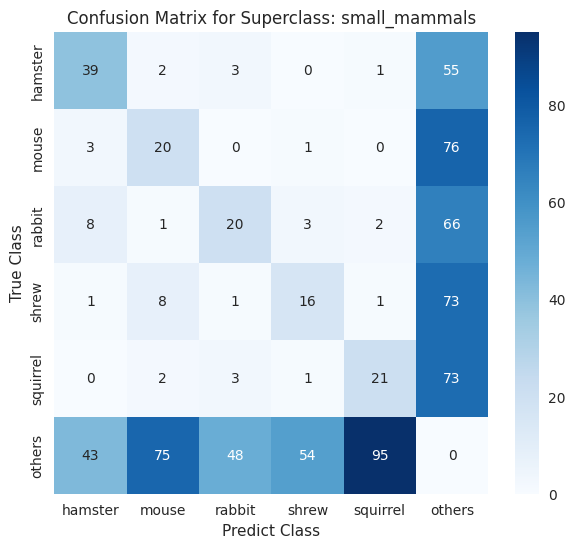

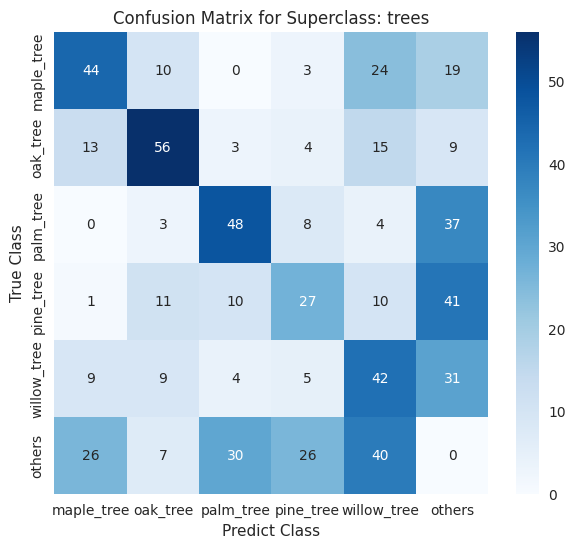

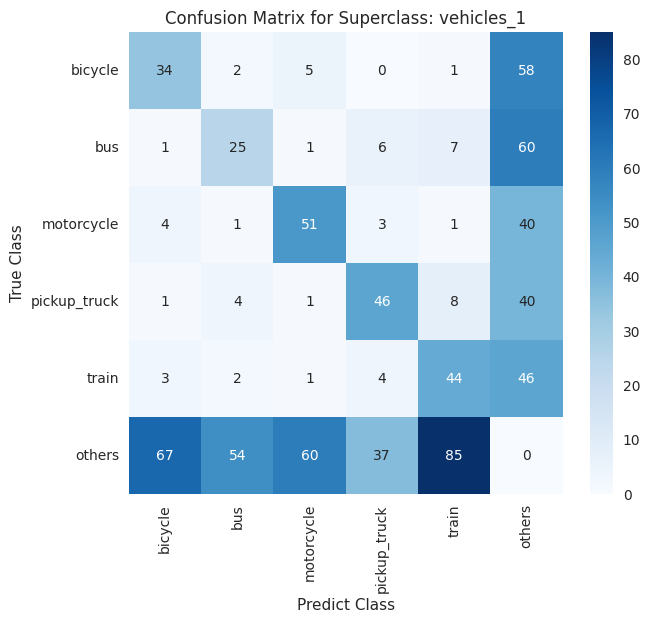

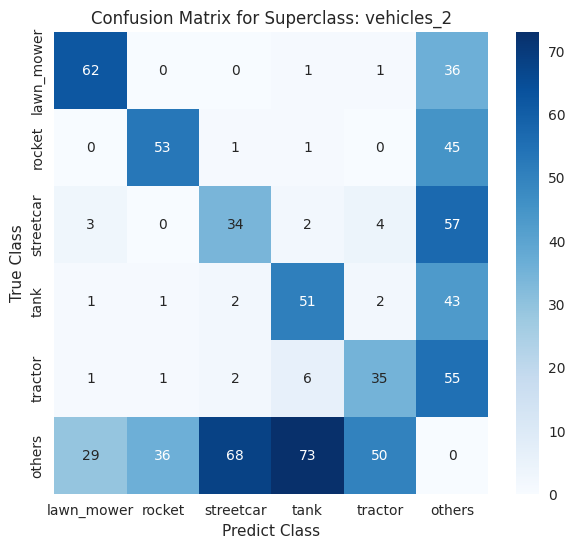

In [17]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  36.47 M 
fwd MACs:                                                               5.7632 GMACs
fwd FLOPs:                                                              11.5428 GFLOPS
fwd+bwd MACs:                                                           17.2897 GMACs
fwd+bwd FLOPs:                                                          34.6284 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod

## **LOAD MODEL AGAIN** 

In [19]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]